# Explore the mekuni adl dataset

In [1]:
## Import modules
import pandas as pd
from bs4 import BeautifulSoup as bs
import os
import re
from collections import Counter
import math
import matplotlib.pyplot as plt

### Read the CSV file

Load the dataset from a CSV file into a pandas DataFrame


In [2]:
df = pd.read_csv('adl_dataset_metadata.csv', encoding='utf')

In [3]:
df.head(2)

,title,place,year,author,birth_year,death_year,xml_file_name,url
0,Bondens Søn ; Vadmelsfolk ; Vredens Børn. - 1919.,København,1918,"Aakjær, Jeppe.",1866,1930,aakjaer06val.xml,https://tekster.kb.dk/text/adl-texts-aakjaer06...
1,Digte 1885-1908. - 1918.,København,1918,"Aakjær, Jeppe.",1866,1930,aakjaer01val.xml,https://tekster.kb.dk/text/adl-texts-aakjaer01...


### Build BeautifulSoup elements from the XML data

In [4]:
# Extract the list of XML file names from the DataFrame
xml_file_names = df['xml_file_name'].to_list()

# Function to read an XML file and parse it using BeautifulSoup
def get_xml_file(file):

    try:
    
        file_path = r'./adl_xml_files_sample_set/' + file
    
        with open(file_path, 'r', encoding='utf-8') as file:
            xml_content = file.read()
    
        soup = bs(xml_content, 'lxml-xml')
    
        return soup

    except FileNotFoundError:
        pass

# Create a list of BeautifulSoup objects for each XML file
xml_soups = [get_xml_file(file) for file in xml_file_names ]

# Create a new DataFrame with XML file names and their corresponding BeautifulSoup objects
df_soup = pd.DataFrame({'xml_file_name': xml_file_names,
                       'soup': xml_soups})

df_soup =  df_soup.dropna()

## Parse data from xml

The data in the column "soup" is beautifulsoup elements, and we can parse the text data inside the different tags using the beautifulsoup methods find_all and get_text.
Skimming the soup / xml I found that first parsing the body tags and second from the "body" tags parse the ""p" and "l" tags would give us most of the relevant text data leaving a lot of the editor notes out. 

In [5]:
# Build a function to extract text data from specific tags (body, p, and l)  within the XML
def get_text_from_body_tags(s):
    body_tags = s.find_all(['body']) 
    p_l_tags = [i.find_all(['p', 'l']) for i in body_tags]
    p_l_tags = [i for y in p_l_tags for i in y]
    text = [i.get_text() for i in p_l_tags]
    text = ' '.join(text).replace('\n', ' ').replace('\t', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply the function to extract text and store it in a new column
df_soup['text'] = df_soup['soup'].apply(lambda s : get_text_from_body_tags(s))

In [6]:
df_soup.head(2)

,xml_file_name,soup,text
3,bagger01val.xml,"[[\n, [\n, <fileDesc xml:id=""idm14062153911272...","Og hvorfor vil I vel skilles ad, Kan Kjærlighe..."
4,baggesen01val.xml,"[[\n, [\n, <fileDesc xml:id=""idm13989371598203...","F ortvivlelse! dig helliges min Sang, Og den, ..."


## Combine the data 
Now I can combine data by merging the two dataframes; df and df_soup. 

The column soup is now longer usefull, so I choose to drop it from the dataframe.

In [7]:
# Merge the original DataFrame with the new DataFrame containing parsed text

mekuni_adl_dataset = pd.merge(df , df_soup, how='left', on='xml_file_name')

# Drop the 'soup' column as it is no longer needed
mekuni_adl_dataset.drop(columns=['soup'], inplace=True)
mekuni_adl_dataset = mekuni_adl_dataset.dropna()

mekuni_adl_dataset.head(2)

,title,place,year,author,birth_year,death_year,xml_file_name,url,text
3,Udvalgte Skrifter.,København,1928,"Bagger, Carl.",1807,1846,bagger01val.xml,https://tekster.kb.dk/text/adl-texts-bagger01v...,"Og hvorfor vil I vel skilles ad, Kan Kjærlighe..."
4,Eventyr og Fortællinger. - 1889.,København,1889,"Baggesen, Jens.",1764,1826,baggesen01val.xml,https://tekster.kb.dk/text/adl-texts-baggesen0...,"F ortvivlelse! dig helliges min Sang, Og den, ..."


## Clean the text

To get more uniform text data I use regex methods. I use .findall() to find all data between word bounderies that is not a whitespace. I use .sub() to avoid numbers, words containing numbers, words with a lenght of 1 or 2; and any sequences of more than one whitespaces. Finaly I lower the letters and returns the clean text. 

In [8]:
# Make a function to clean the text using regular expressions
def clean(text): 
    
    text = ' '.join(re.findall(r'\b\S+\b', text))

    # Remove numbers and words containing numbers
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    
    # Remove short words (length 1 or 2)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text) 

    # Convert text to lowercase
    text = text.lower()

    # return the text
    return text
    
# Apply the cleaning function to the text column
mekuni_adl_dataset['clean_text'] = mekuni_adl_dataset['text'].apply(lambda x: clean(x))

## Remove stopwords

I want to apply a collocation tool downstream, and in that I do not wish to include stopword, so I choose to make new text strings without stopwords, to be able to get better results out of a my collocation analysis.

I the folder "stopwords" I have a txt file with stopwords. I read the txt into the script, make it into a list, and with the make place for adding additional stuff to the list. 

In [9]:
# Load a list of danish stopwords from a text file
sw_file = r'stopwords/adl_dataset_stopwords.txt'

with open(sw_file, 'r', encoding='utf-8') as f:
    stop_words = f.read().split()
    # Add additional stopwords
    stop_words.extend(['_', '/', "'"])

# Define a function to remove stopwords from the text
def remove_stopwords(clean_text):   
    # Change text to wordlist
    tokens = clean_text.split()
    tokens_wo_stopwords = [i for i in tokens if i.lower() not in stop_words]
    clean_text_wo_stopwords = ' '.join(tokens_wo_stopwords)
    return clean_text_wo_stopwords

# Apply the stopword removal function
mekuni_adl_dataset['clean_text_wo_stopwords'] = mekuni_adl_dataset['clean_text'].apply( lambda x : remove_stopwords(x))

In [10]:
mekuni_adl_dataset.head(2)

,title,place,year,author,birth_year,death_year,xml_file_name,url,text,clean_text,clean_text_wo_stopwords
3,Udvalgte Skrifter.,København,1928,"Bagger, Carl.",1807,1846,bagger01val.xml,https://tekster.kb.dk/text/adl-texts-bagger01v...,"Og hvorfor vil I vel skilles ad, Kan Kjærlighe...",hvorfor vil vel skilles kan kjærlighed skifte...,skilles kjærlighed skiftes had harmfuldt sind ...
4,Eventyr og Fortællinger. - 1889.,København,1889,"Baggesen, Jens.",1764,1826,baggesen01val.xml,https://tekster.kb.dk/text/adl-texts-baggesen0...,"F ortvivlelse! dig helliges min Sang, Og den, ...",ortvivlelse dig helliges min sang den som hæn...,ortvivlelse helliges sang hænger hang hænge ør...


## Collocation
Add or replace the keywords with your own words.

In [11]:
# Define keywords for collocation analysis
keywords = ['fader', 'moder', 'barn']

in_data_list = ' '.join(mekuni_adl_dataset['clean_text_wo_stopwords']).split()

# Initialize a dictionary to count keyword proximities
keyword_proximity_counts = {keyword: Counter() for keyword in keywords}
window_size = 10

# Count the proximity of words around each keyword
for i, token in enumerate(in_data_list):
    if token in keywords:
        # Define the window around the keyword
        start = max(0, i - window_size)
        end = min(len(in_data_list), i + window_size + 1)
        # Count terms in the window, excluding the keyword itself
        for j in range(start, end):
            if j != i:
                keyword_proximity_counts[token][in_data_list[j]] += 1

# Filter out terms with low counts
filtered_keyword_proximity_counts = {
    keyword: Counter({term: count for term, count in counts.items() if count >= 80})
    for keyword, counts in keyword_proximity_counts.items()}

## Visualise the collocations
If I print the content of the variable "filtered_keyword_proximity_counts" we can watch the different keywords together with the collocations. It is the collocations that exists after we have removed stopwords and defined a window size of 10. It can be a bit confusing to watch the data in the printed format, so I chose to use math plot lib to visualise the colllocations with bar plots.  

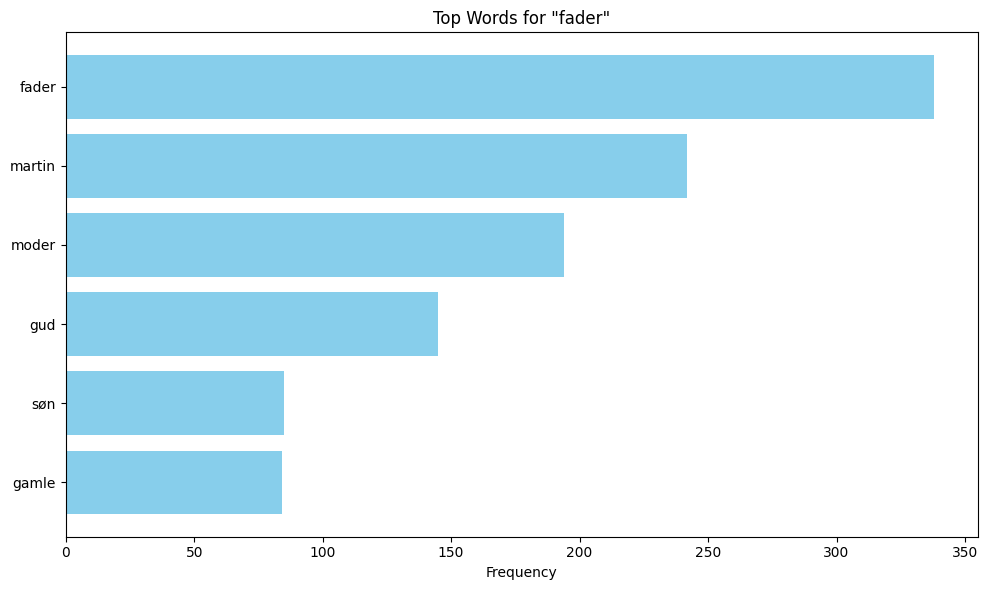

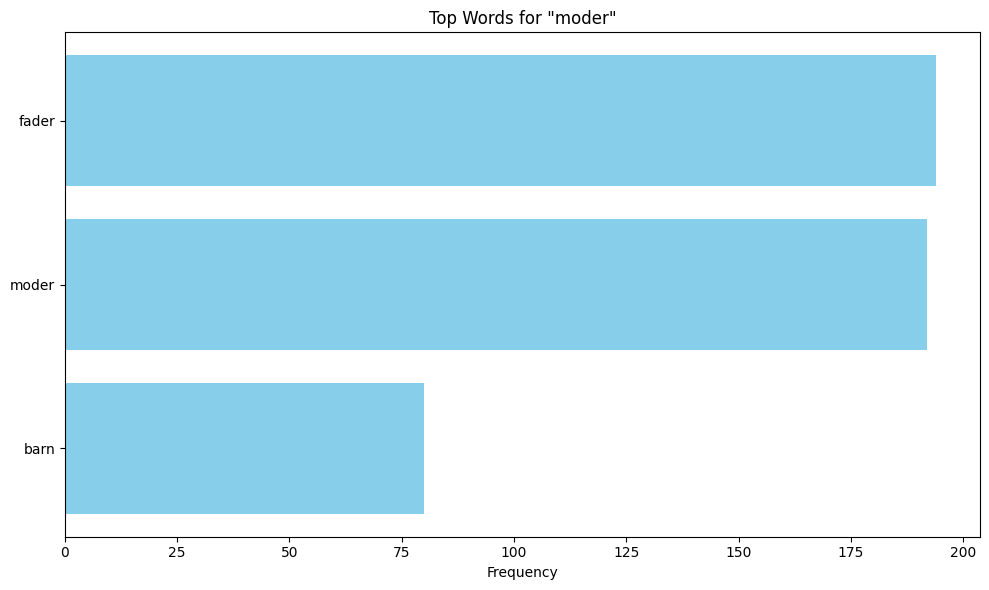

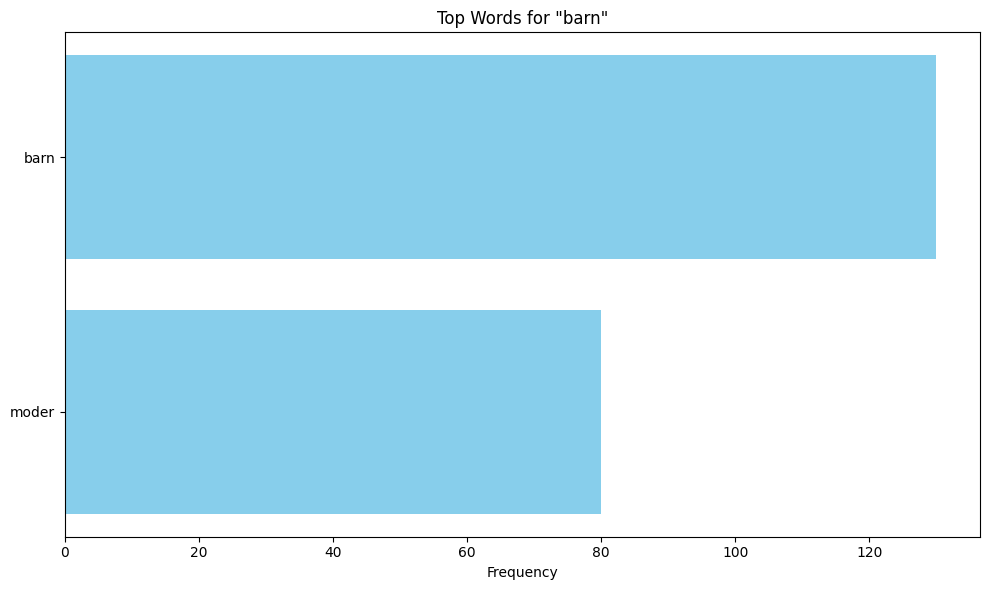

In [12]:
# Convert each group's Counter to a DataFrame
dfs = []
for keyword, counter in filtered_keyword_proximity_counts.items():
    df = pd.DataFrame(counter.items(), columns=['Word', 'Frequency'])
    df['Keyword_Group'] = keyword
    dfs.append(df)

# Concatenate all dataframes
all_data = pd.concat(dfs, ignore_index=True)

# Create individual bar charts for each keyword group
for keyword in filtered_keyword_proximity_counts.keys():
    df_subset = all_data[all_data['Keyword_Group'] == keyword]
    plt.figure(figsize=(10,6))
    df_subset = df_subset.sort_values(by='Frequency', ascending=False).head(10)
    plt.barh(df_subset['Word'], df_subset['Frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top Words for "{keyword}"')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
